In [1]:
# Limpieza de la base de datos
import pandas as pd
import numpy as np

df = pd.read_csv(  # Lectura de datos
    "../archive/BBDD Población Chile (1b).xlsx - Tabla ajustada población .csv",
    index_col=0
)


df = df.T  # Transposicion

# notacion europea a float
for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )

df = df.replace(["NaN", "nan", "NAN", "None", ""], np.nan)
df = df.fillna(0)

df = df.apply(pd.to_numeric)




print(df)

df.to_csv("../data/output.csv")

      Población total de jovenes (0-14)  Población total de adultos (15-64)  \
2002                          4156812.0                          10288683.0   
2003                          4116188.0                          10456445.0   
2004                          4057629.0                          10640163.0   
2005                          3991476.0                          10826184.0   
2006                          3921521.0                          11017529.0   
2007                          3864328.0                          11200341.0   
2008                          3823083.0                          11375175.0   
2009                          3792259.0                          11541067.0   
2010                          3767767.0                          11697176.0   
2011                          3748933.0                          11851404.0   
2012                          3732105.0                          11998670.0   
2013                          3712426.0             

In [38]:
#regresion
import statsmodels.api as sm

 #Modelo jovenes

x_J=df[["Población total de adultos (15-64)","Población total de jovenes (0-14)"]]
y_J=df["dJ"]
#x_J=sm.add_constant(x_J,prepend=False)
modelo_J = sm.OLS(y_J,x_J).fit()
coef_j=modelo_J.params.to_dict()

# Modelo adultos

x_A=df[["Población total de jovenes (0-14)","Población total de adultos (15-64)"]]
y_A=df["dA"]
#x_A=sm.add_constant(x_A,prepend=False)
modelo_A=sm.OLS(y_A,x_A).fit()
coef_A=modelo_A.params.to_dict()

# Modelo mayores

x_E=df[["Población total de adultos (15-64)","Poblacion total mayores (65+ años)"]]
y_E=df["dM"]
x_E=sm.add_constant(x_E,prepend=False)
modelo_E=sm.OLS(y_E,x_E).fit()
coef_E=modelo_E.params.to_dict()

print(modelo_J.summary())
print(modelo_A.summary())
print(modelo_E.summary())


                                 OLS Regression Results                                
Dep. Variable:                     dJ   R-squared (uncentered):                   0.650
Model:                            OLS   Adj. R-squared (uncentered):              0.616
Method:                 Least Squares   F-statistic:                              19.48
Date:                Fri, 14 Nov 2025   Prob (F-statistic):                    1.64e-05
Time:                        08:47:43   Log-Likelihood:                         -259.39
No. Observations:                  23   AIC:                                      522.8
Df Residuals:                      21   BIC:                                      525.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

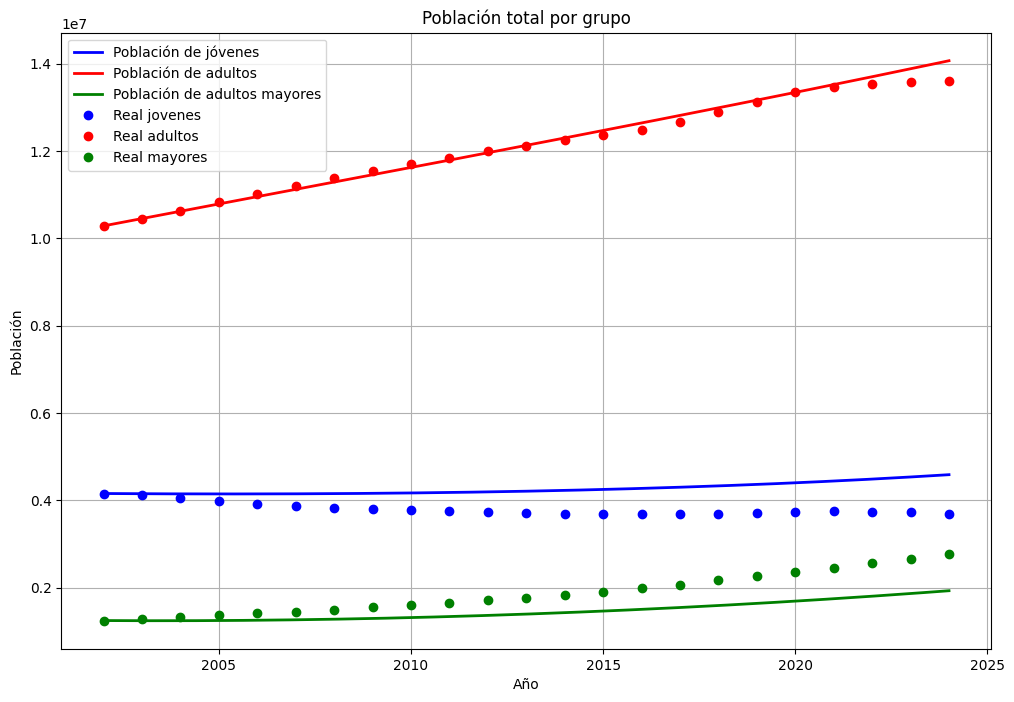

In [40]:
# Graficación por Runge-Kutta 4 (consistente en el orden del estado)
import numpy as np
import matplotlib.pyplot as plt

def sistema_edos(t, y):
    # y = [J, A, E]
    jt, at, et = y

    # COEFICIENTES
    c1 = 0.0113 # tasa de natalidad
    c2 = -0.0411  # tasa de mortalidad jóvenes
    const1 = -2.929e+05
    tj= 0.0392 # transicion jovenes
    c3 =  -0.0004  # tasa de mortalidad adultos
    #const2= 1.442e+06
    ta=0.0207 # transicion adultos
    c4 = 0.0107  # tasa de mortalidad mayores
    const3=-2.048e+05

    # ECUACIONES
    dyJ = c1*at-c2*jt+const1
    dyA = tj*jt-c3*at#+const2
    dyE = ta*at-c4*et+const3
    return [dyJ, dyA, dyE]

def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E] en 2002
y0 = [4156812.0, 10288683.0, 1246206.0]
t0, tf, h = 0, 22, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

years = 2002 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Datos del modelo

ax.plot(years, y[:, 0], 'b-', linewidth=2, label='Población de jóvenes')
ax.plot(years, y[:, 1], 'r-', linewidth=2, label='Población de adultos')
ax.plot(years, y[:, 2], 'g-', linewidth=2, label='Población de adultos mayores')

# Datos reales

years_real =  df.index.astype(int)

ax.plot(years_real,df["Población total de jovenes (0-14)"],'bo',markersize=6,label="Real jovenes")
ax.plot(years_real,df["Población total de adultos (15-64)"],'ro',markersize=6,label="Real adultos")
ax.plot(years_real,df["Poblacion total mayores (65+ años)"],'go',markersize=6,label="Real mayores")

ax.set_title('Población total por grupo')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
ax.grid(True)
ax.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

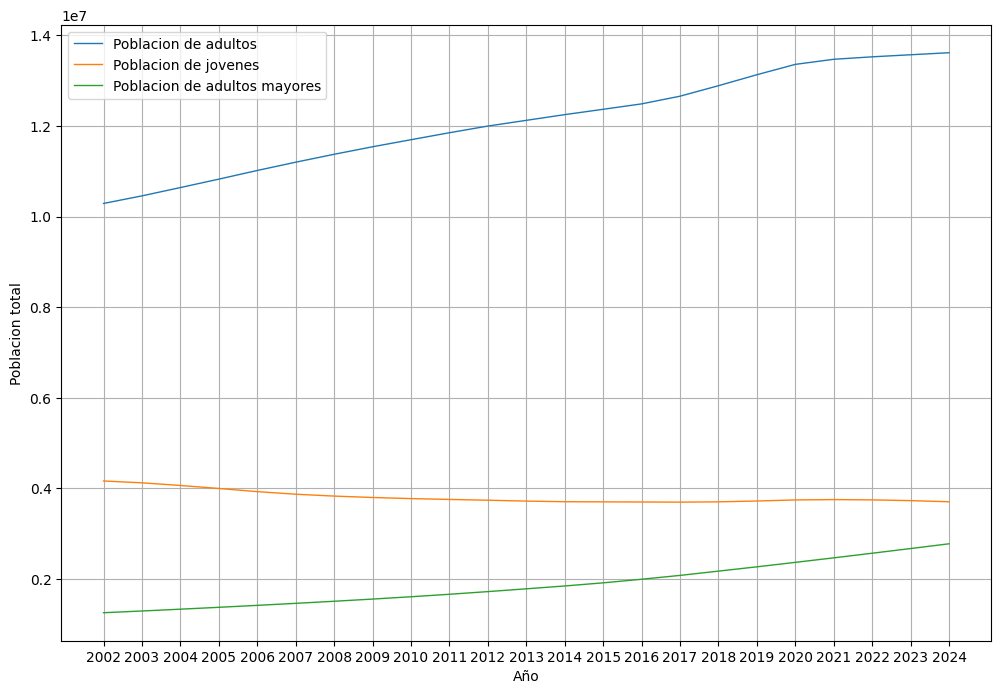

In [26]:
# hacer la grafica de los datos reales
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(df["Población total de adultos (15-64)"],linewidth=1,label="Poblacion de adultos")
ax.plot(df["Población total de jovenes (0-14)"],linewidth=1,label="Poblacion de jovenes")
ax.plot(df["Poblacion total mayores (65+ años)"],linewidth=1,label="Poblacion de adultos mayores")
ax.set_xlabel("Año")
ax.set_ylabel("Poblacion total")
ax.grid(True)
ax.legend()
plt.show

In [18]:
print(df.index)

Index(['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021', '2022', '2023', '2024'],
      dtype='object')
